<a href="https://colab.research.google.com/github/rrl7012005/Competitions-and-Datasets/blob/main/CIFAR_10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [ ]:
ds, info = tfds.load('Cifar10', as_supervised=True, split=['train', 'test'], with_info=True)

train_ds = ds[0]
test_ds = ds[1]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.GLY5FF_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.GLY5FF_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

In [ ]:
print(len(train_ds))
print(len(test_ds))

train_ds, test_ds

50000
10000


(<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [ ]:
class_names = info.features['label'].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

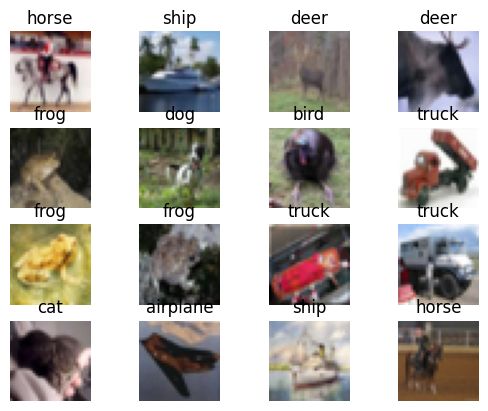

In [ ]:
for i, (image, label) in enumerate(train_ds.take(16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis('off')

Normalize images and create pipeline

In [ ]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.2),
#     tf.keras.layers.RandomContrast(0.1)
# ])

def augment(image, label):
  return data_augmentation(image), label

In [ ]:
def rescale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image, label

batch_size = 32

# train_dataset = train_ds.take(45000).batch(batch_size).map(augment).map(rescale).prefetch(tf.data.AUTOTUNE)
train_dataset = train_ds.take(45000).batch(batch_size).map(rescale).prefetch(tf.data.AUTOTUNE)
val_dataset = train_ds.skip(45000).batch(batch_size).map(rescale).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(rescale).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1407, 157, 313)

#Modelling

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
rr = 1e-2
dr = 0.3

model0 = tf.keras.Sequential([
    InputLayer(input_shape=(32, 32, 3)),

    Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(dr),

    Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(dr),

    Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(dr),

    Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    MaxPooling2D(2),
    Dropout(dr),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    Dropout(dr),
    Dense(128, activation='relu', kernel_regularizer=l2(rr)),
    BatchNormalization(),
    Dropout(dr),
    Dense(10, activation='softmax')
])

model0.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_152 (Conv2D)                  │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_123              │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_153 (Conv2D)                  │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_124              │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_154 (Conv2D)                  │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_125              │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_155 (Conv2D)                  │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_126              │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_156 (Conv2D)                  │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_127              │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_157 (Conv2D)                  │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_128              │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_64 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_158 (Conv2D)                  │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_129              │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,308,234 (20.25 MB)

 Trainable params: 5,303,434 (20.23 MB)

 Non-trainable params: 4,800 (18.75 KB)

In [ ]:
model0.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              patience=2,
                              min_lr=1e-6,
                              verbose=1)

history = model0.fit(train_dataset, validation_data=val_dataset, epochs=15, verbose=1, callbacks=[reduce_lr])

Epoch 1/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step - accuracy: 0.5563 - loss: 1.5681 - val_accuracy: 0.5626 - val_loss: 1.6604 - learning_rate: 3.0000e-04
Epoch 2/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.5765 - loss: 1.6031 - val_accuracy: 0.5868 - val_loss: 1.6945 - learning_rate: 3.0000e-04
Epoch 3/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.5807 - loss: 1.6191 - val_accuracy: 0.5856 - val_loss: 1.6103 - learning_rate: 3.0000e-04
Epoch 4/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.5897 - loss: 1.5967 - val_accuracy: 0.5774 - val_loss: 1.5893 - learning_rate: 3.0000e-04
Epoch 5/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.5976 - loss: 1.5975 - val_accuracy: 0.6556 - val_loss: 1.4147 - learning_rate: 3.0000e-04
Epoch 6/15
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.6036 - loss: 1.5746 - val_accuracy: 0.6402 - val_loss: 1.4654 - learning_rate: 3.0000e-04
Epoch 7/15
1406/1407 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model0.evaluate(test_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8522 - loss: 0.7024


[0.709204912185669, 0.8521000146865845]